In [18]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
algorithm_globals.random_seed = 12345

import os
import cv2
import tarfile
import numpy as np
from tensorflow.keras.utils import to_categorical

In [ ]:
# Directory paths
base_dir = "C:\\Users\\Aniket_kumar\\Downloads\\ILSVRC2012"
German_Shepherd_dir = os.path.join(base_dir, 'German_Shepherd')
Border_Terrier_dir = os.path.join(base_dir, 'Border_Terrier')
Briard_dir = os.path.join(base_dir, 'Briard')
English_Foxhound_dir = os.path.join(base_dir, 'English_Foxhound')
Ibizan_Hound_dir = os.path.join(base_dir, 'Ibizan_Hound')


In [20]:
# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Function to load and preprocess images
def load_and_preprocess_images(directory, img_height, img_width):
    images = []
    labels = []
    
    # Define a mapping from class names to numerical labels
    label_map = {'German_Shepherd': 0, 'Border_Terrier': 1, 'Briard': 2, 'English_Foxhound': 3, 'Ibizan_Hound': 4}

    # Iterate over each class name and its corresponding label
    for class_name, class_label in label_map.items():
        # Construct the path to the tar file for the class
        tar_file_path = os.path.join(directory, class_name + '.tar')
        # Create a temporary directory for extracting the contents of the tar file
        temp_extract_dir = os.path.join(directory, 'temp_' + class_name)
        os.makedirs(temp_extract_dir, exist_ok=True)

        # Open the tar file and extract its contents
        with tarfile.open(tar_file_path, 'r') as tar_ref:
            tar_ref.extractall(temp_extract_dir)

        # Process each image in the extracted directory
        class_dir = os.path.join(temp_extract_dir)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            # Read the image using OpenCV
            image = cv2.imread(img_path)
            if image is not None:
                # Resize the image to the desired dimensions
                image = cv2.resize(image, (img_width, img_height))
                # Normalize the image pixel values to the range [0, 1]
                image = image / 255.0
                # Append the processed image to the images list
                images.append(image)
                # Append the corresponding label to the labels list
                labels.append(class_label)

    # Convert the images list to a NumPy array and the labels list to a categorical NumPy array
    return images, labels


X, y = load_and_preprocess_images(base_dir, IMG_HEIGHT, IMG_WIDTH)


In [97]:
images, labels = X,y
print(len(images),len(labels))
print(len(X[0]))

821 821
224


In [98]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state= 246)
np.array(train_images) 
np.array(train_labels) 


array([3, 1, 0, 0, 0, 1, 4, 0, 1, 1, 0, 0, 3, 0, 4, 2, 2, 2, 3, 2, 2, 3,
       0, 0, 1, 1, 0, 1, 0, 2, 2, 4, 3, 3, 2, 4, 4, 4, 2, 0, 0, 0, 0, 2,
       0, 1, 4, 2, 2, 3, 3, 1, 3, 0, 1, 1, 1, 0, 1, 4, 3, 1, 1, 2, 3, 1,
       2, 4, 3, 4, 1, 1, 0, 3, 1, 1, 3, 0, 2, 4, 0, 2, 2, 2, 1, 1, 1, 2,
       2, 2, 4, 2, 1, 4, 1, 0, 4, 0, 1, 3, 3, 0, 0, 1, 0, 1, 3, 3, 4, 0,
       4, 4, 2, 4, 0, 3, 3, 3, 4, 0, 1, 4, 3, 1, 2, 0, 3, 1, 0, 4, 1, 4,
       4, 0, 2, 1, 4, 3, 2, 1, 2, 4, 4, 0, 1, 4, 0, 4, 1, 0, 0, 3, 0, 2,
       2, 2, 1, 2, 3, 2, 4, 1, 2, 2, 0, 4, 0, 3, 4, 3, 3, 0, 2, 1, 1, 2,
       4, 1, 2, 2, 4, 2, 1, 4, 3, 4, 1, 3, 0, 0, 1, 0, 1, 3, 1, 1, 4, 3,
       4, 3, 3, 2, 2, 4, 4, 1, 3, 3, 2, 4, 3, 1, 2, 2, 3, 2, 3, 2, 2, 2,
       2, 0, 4, 4, 0, 3, 3, 1, 1, 0, 2, 4, 4, 2, 3, 4, 0, 4, 3, 0, 3, 2,
       3, 0, 1, 2, 4, 2, 4, 0, 2, 3, 3, 0, 1, 3, 4, 3, 3, 0, 2, 3, 1, 3,
       2, 1, 2, 1, 2, 4, 1, 1, 4, 4, 4, 4, 3, 0, 4, 1, 2, 3, 1, 2, 1, 1,
       1, 4, 2, 4, 4, 2, 3, 2, 0, 1, 2, 2, 3, 4, 3,

In [99]:
# Define the convolutional circuit
def conv_circuit(num_qubits, layers, params):
    qc = QuantumCircuit(num_qubits, name="Ansatz")
    for _ in range(layers):
        for i in range(num_qubits):
            qc.rx(params[3 * i], i)
            qc.ry(params[3 * i + 1], i)
            qc.rz(params[3 * i + 2], i)
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)
        qc.cx(num_qubits - 1, 0)
    return qc

# Define convolutional layer function
def conv_layer(num_qubits, param_prefix, layers=1):
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    return conv_circuit(num_qubits, layers, params)

In [100]:
# Define a pooling circuit for two qubits
def pool_circuit(params):
    qc = QuantumCircuit(2)
    qc.rz(-np.pi / 2, 1)
    qc.cx(1, 0)
    qc.rz(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    qc.ry(params[2], 1)
    return qc

# Define the pooling layer for a given number of qubit pairs
def pool_layer(qubit_pairs, param_prefix):
    num_qubits = sum([len(pair) for pair in qubit_pairs])
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=len(qubit_pairs) * 3)
    for q1, q2 in qubit_pairs:
        layer_params = params[param_index:param_index + 3]  # Use 3 params for each pool
        qc = qc.compose(pool_circuit(layer_params), [q1, q2])
        qc.barrier()
        param_index += 3
    return qc

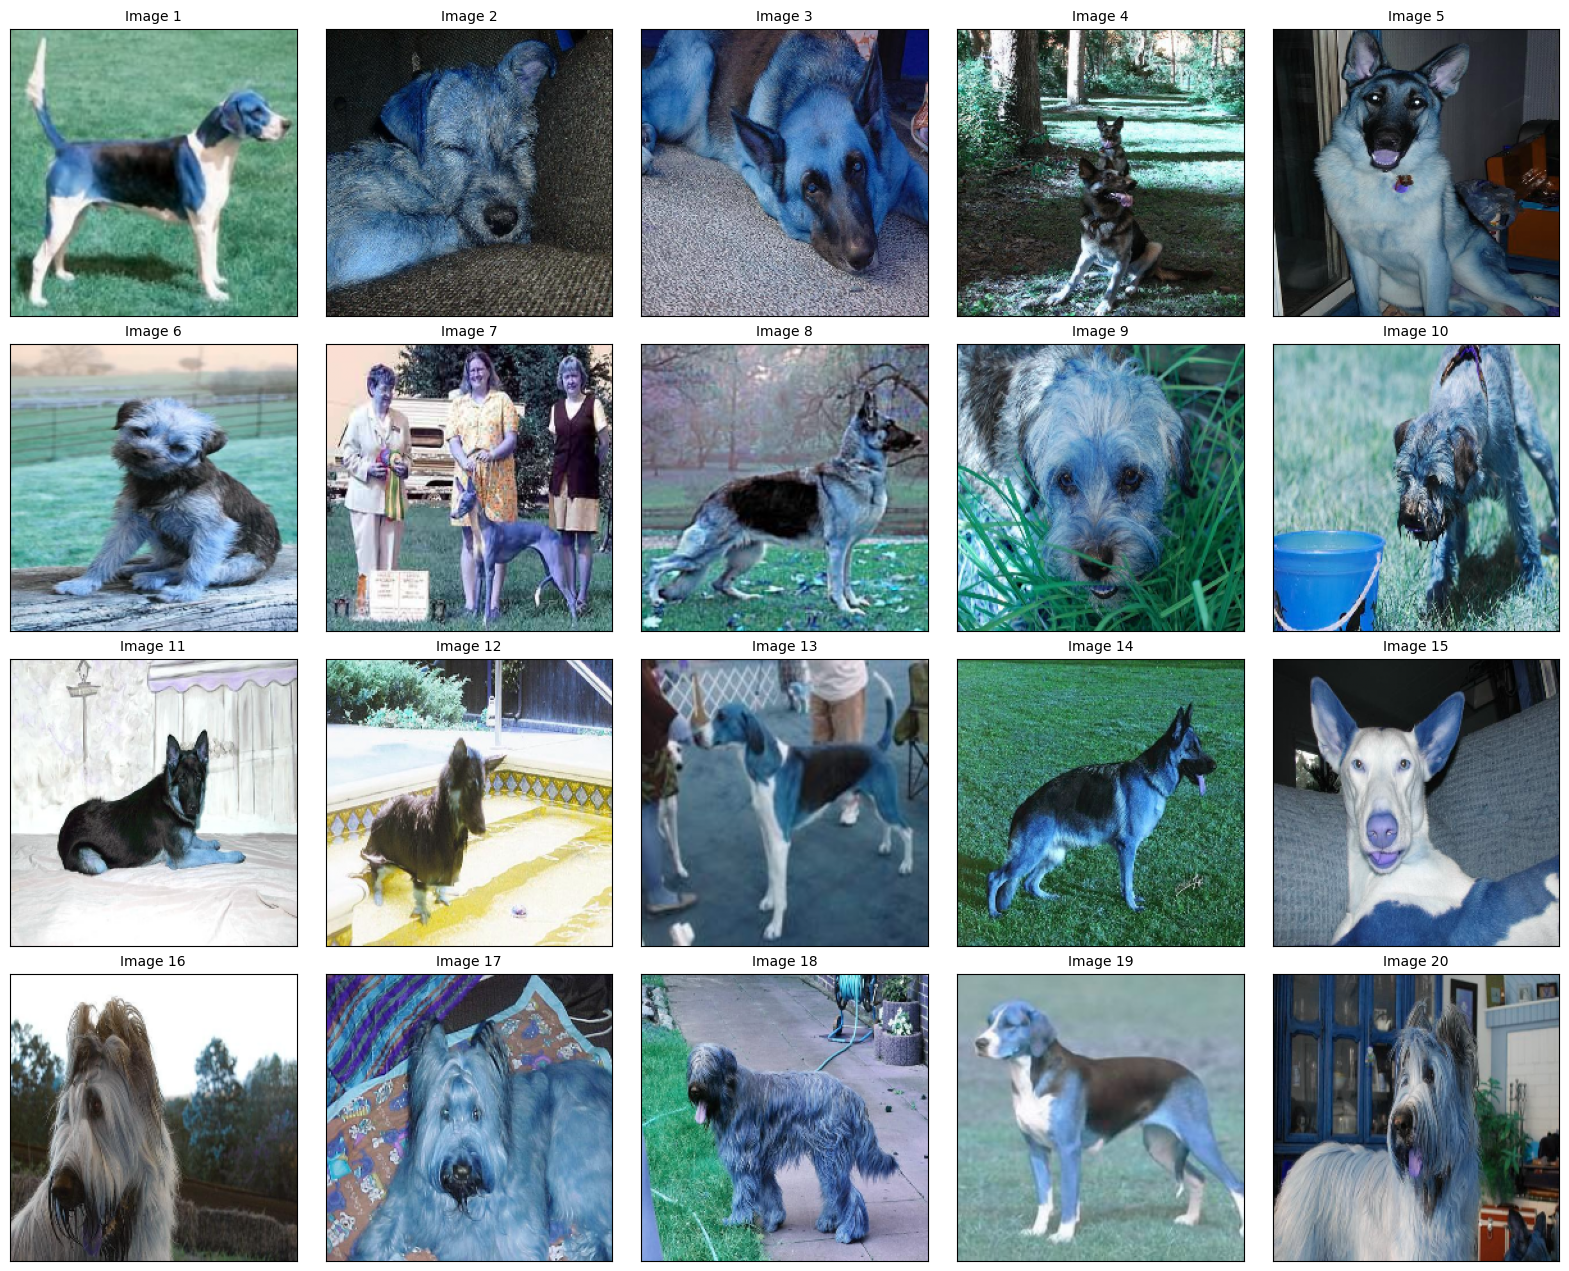

In [101]:
def plot_images(images, n, img_height, img_width):
    # Determine the number of rows and columns for the grid
    cols = int(np.ceil(np.sqrt(n)))
    rows = int(np.ceil(n / cols))
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), subplot_kw={"xticks": [], "yticks": []})
    
    # Flatten the axes array if there's only one row or column
    if rows == 1:
        axes = axes.reshape(1, -1)
    if cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot images
    for i in range(n):
        if i < len(images):
            ax = axes[i // cols, i % cols]
            ax.imshow(images[i])
            ax.set_title(f'Image {i+1}', fontsize=10)
        else:
            # Hide empty subplots if n < number of subplots
            axes[i // cols, i % cols].axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


n_images_to_show = 20  # Number of images you want to display
plot_images(train_images, n_images_to_show, IMG_HEIGHT, IMG_WIDTH)


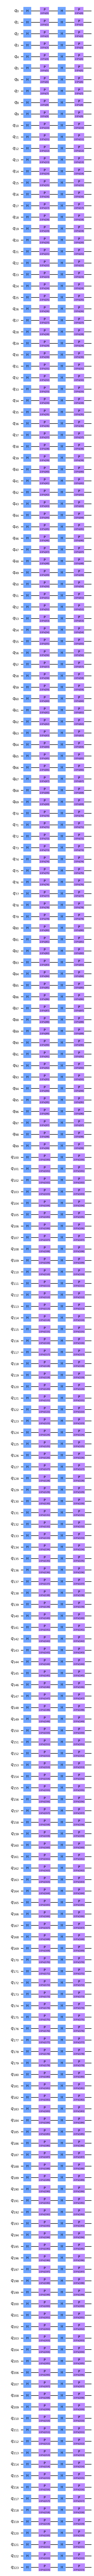

In [102]:
# Feature map for 224 qubits
feature_map = ZFeatureMap(224)
feature_map.decompose().draw("mpl", style="clifford")


In [103]:
ansatz = QuantumCircuit(224, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(224, "c1"), list(range(224)), inplace=True)

# First Pooling Layer (224 -> 112 qubits)
ansatz.compose(pool_layer([(i, i+112) for i in range(112)], "p1"), list(range(224)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(112, "c2"), list(range(112)), inplace=True)

# Second Pooling Layer (112 -> 56 qubits)
ansatz.compose(pool_layer([(i, i+56) for i in range(56)], "p2"), list(range(112)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(56, "c3"), list(range(56)), inplace=True)

# Third Pooling Layer (56 -> 28 qubits)
ansatz.compose(pool_layer([(i, i+28) for i in range(28)], "p3"), list(range(56)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(224)
circuit.compose(feature_map, range(224), inplace=True)
circuit.compose(ansatz, range(224), inplace=True)

# Define multiple observables for multi-class classification
observables = [
    SparsePauliOp.from_list([("Z" + "I" * 223, 1)]),
    SparsePauliOp.from_list([("I" + "Z" + "I" * 222, 1)]),
    SparsePauliOp.from_list([("I" * 2 + "Z" + "I" * 221, 1)]),
    SparsePauliOp.from_list([("I" * 3 + "Z" + "I" * 220, 1)]),
    SparsePauliOp.from_list([("I" * 4 + "Z" + "I" * 219, 1)])
]

# Define the QNN for multiclass classification
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observables,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)


In [84]:
# circuit.draw("mpl", style="clifford")

In [104]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
objective_func_vals = []  # Initialize a list to store the objective function values

In [139]:
from sklearn.preprocessing import MinMaxScaler

# Assume train_images is your dataset with shape (574, height, width)
# Flatten the images and scale them to [0, 1]
train_images_flat = np.array(train_images).reshape(len(train_images), -1)
scaler = MinMaxScaler()
train_images_normalized = scaler.fit_transform(train_images_flat)

# Ensure each image has exactly 224 features (columns)
# You can trim, reshape, or pad the images to fit the 224 qubits
if train_images_normalized.shape[1] > 224:
    train_images_quantum = train_images_normalized[:, :224]  # Trim excess features
elif train_images_normalized.shape[1] < 224:
    # Pad with zeros if fewer than 224 features
    padding = np.zeros((train_images_normalized.shape[0], 224 - train_images_normalized.shape[1]))
    train_images_quantum = np.hstack((train_images_normalized, padding))
else:
    train_images_quantum = train_images_normalized

print(train_images_quantum.shape)  


(574, 224)


In [140]:
np.array(train_images_quantum).shape,np.array(train_labels).shape

((574, 224), (574,))

In [ ]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
)

classifier.fit(np.array(train_images_quantum),np.array(train_labels))

In [17]:
print(f"Accuracy from the train data : {np.round(100 * classifier.score(train_images_quantum,np.array(train_labels)), 2)}%")

Accuracy from the train data : 25.78%
